Plan
1. Read data, apply train and validation split.
2. Process data:

   2.1. Keep "feature_1" records with "A" values.

   2.2. Impute missing values.
   
   2.3. Convert target string values to integers.

3. Run Feature Engineering.
5. Run FS.
6. Run GridsearchCV parameter tuning with RF.
7. Preprocess validation data (imputation, FEng etc.).
8. Make prediction & evaluation on validation set:

   7.1. Predict "Low" if "feature_1" not "A".

   7.2. Use ML to predict the rest.

   7.3. Concatenate datasets.

   7.4. Assess accuracy & f-1 score.

9. Make prediction on unseen test data.

In [64]:
from dvclive import Live
import joblib
import numpy as np
import logging
from matplotlib import pyplot as plt
import pandas as pd 
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Specify attributes - https://docs.python.org/3/library/logging.html#logging.LogRecord
logging.basicConfig(filename='../logs/experiments.log',
                    level=logging.DEBUG,
                    format='%(levelname)s: %(asctime)s %(message)s') #Can optionally add %(processName)s 

# Adding a StreamHandler to also log to console
# console_handler = logging.StreamHandler()
# console_handler.setFormatter(logging.Formatter('%(levelname)s: %(asctime)s %(message)s'))
# logging.getLogger().addHandler(console_handler)

### 1. Read data

In [84]:
df = pd.read_csv('../data/train.csv', parse_dates=['job_posted_date'])

/tmp/ipykernel_21792/3358507925.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/train.csv', parse_dates=['job_posted_date'])


In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=1)
df_train.to_csv('../data/interim/train_data.csv', index=False)
df_valid.to_csv('../data/interim/valid_data.csv', index=False)

### 2. Preprocess
2.1. Keep only records with "feature_1" equals "A".

In [86]:
df_train = df_train.query('feature_1 == "A"').reset_index(drop=True)

In [87]:
df_train = df_train.drop(columns=['obs', 'job_posted_date', 'feature_1'])
df_train.head(2)

,job_title,salary_category,job_state,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,Job_Title_10,High,NY,0.7081,False,False,False,False,False,False,...,-0.176141,-0.257729,-0.437192,-0.261142,0.011111,-0.422159,0.037184,-0.872810,-0.960562,-0.152903
1,Others,Low,CA,0.4640,False,False,False,False,False,True,...,-0.752268,-0.797484,-0.391935,-0.457335,0.388516,-0.612265,-0.231584,-0.932317,-0.726788,-0.159043


### 2.2. Impute missing values

In [88]:
[col for col in df_train.columns if df_train[col].isnull().sum() > 0]

['job_state', 'feature_10']

<Axes: >

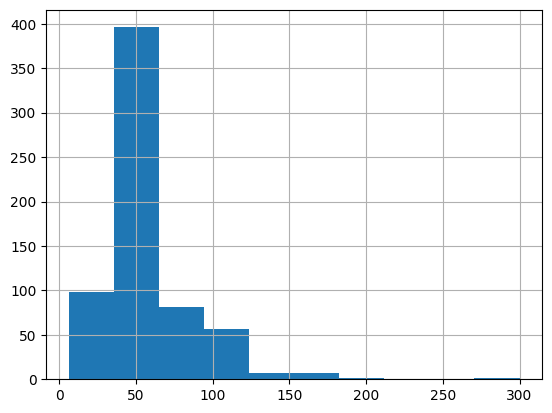

In [89]:
df_train['feature_10'].hist()

In [90]:
df_train['job_state'] = df_train['job_state'].fillna(df_train['job_state'].mode()[0])
df_train['feature_10'] = df_train['feature_10'].fillna(df_train['feature_10'].median())

### 2.3. Turn string target to integer

In [91]:
df_train['salary_category_num'] = df_train['salary_category'].map({'High': 2, 'Medium': 1, 'Low':0})
df_train.drop(columns=['salary_category'], inplace=True)

### 3. Run Feature Engineering
- Target encode categorical columns.
- Turn Boolean column values to integers.

In [92]:
df_train.head(2)

,job_title,job_state,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300,salary_category_num
0,Job_Title_10,NY,0.7081,False,False,False,False,False,False,False,...,-0.257729,-0.437192,-0.261142,0.011111,-0.422159,0.037184,-0.872810,-0.960562,-0.152903,2
1,Others,CA,0.4640,False,False,False,False,False,True,False,...,-0.797484,-0.391935,-0.457335,0.388516,-0.612265,-0.231584,-0.932317,-0.726788,-0.159043,0


In [93]:
df_stats = df_train.groupby('job_title').agg({'salary_category_num': 'mean'}).reset_index()
mapping_jobtitle = df_stats.set_index('job_title')['salary_category_num'].to_dict()
df_train['job_title'] = df_train['job_title'].map(mapping_jobtitle)

In [94]:
df_stats_state = df_train.groupby('job_state').agg({'salary_category_num': 'mean'}).reset_index()
mapping_jobstate = df_stats_state.set_index('job_state')['salary_category_num'].to_dict()
df_train['job_state'] = df_train['job_state'].map(mapping_jobstate)

In [95]:
for col in [col for col in df_train.columns if df_train[col].dtype == 'bool']:
    df_train[col] = df_train[col].map({True: 1, False: 0})

In [96]:
df_train.head()

,job_title,job_state,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300,salary_category_num
0,0.738095,1.202073,0.7081,0,0,0,0,0,0,0,...,-0.257729,-0.437192,-0.261142,0.011111,-0.422159,0.037184,-0.872810,-0.960562,-0.152903,2
1,1.024781,1.034707,0.4640,0,0,0,0,0,1,0,...,-0.797484,-0.391935,-0.457335,0.388516,-0.612265,-0.231584,-0.932317,-0.726788,-0.159043,0
2,1.024781,1.202073,0.5232,0,0,0,1,1,0,0,...,-0.394131,-0.475661,-0.107946,-0.096748,-0.566211,-0.045679,-0.623305,-0.820986,-0.034159,0
3,1.024781,1.034707,0.6170,0,0,0,1,1,1,0,...,-0.174653,-0.540886,-0.480234,-0.082029,-0.275534,-0.372701,-0.945608,-1.178964,0.087829,2
4,1.024781,1.034707,0.4586,0,0,0,1,0,0,0,...,-0.326449,-0.426774,-0.419691,-0.039451,-0.365965,0.078289,-0.754860,-1.041070,-0.137594,0


### 4. Run Feature Selection 

In [81]:
df_train = pd.read_csv('../data/interim/train_data.csv')
df_train['salary_category_num'] = df_train['salary_category'].map({'High': 2, 'Medium': 1, 'Low':0})


In [114]:
X = df_train.drop(columns=['salary_category_num'])
y = df_train['salary_category_num']

In [115]:
X_fs = X.copy(deep=True)
scaler = MinMaxScaler()
X_fs = scaler.fit_transform(X_fs)

In [116]:
selector = SelectKBest(score_func=chi2, k=9)
feature_names = X.columns
#fit = selector.fit(X_fs, y)
X_new = selector.fit_transform(X_fs, y)

# Get selected feature names
selected_features = feature_names[selector.get_support()]

selected_features

Index(['feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_8',
       'feature_12', 'job_desc_012', 'job_desc_021', 'job_desc_299'],
      dtype='object')

In [117]:
run_timestamp = pd.to_datetime('now').strftime('%Y%m%d_%H-%M-%S')

In [118]:
df_output = df_train[selected_features]
df_output['salary_category'] = y
df_output['salary_category'] = df_output['salary_category'].map({0: 'Low', 1: 'Medium', 2: 'High'})
df_output.to_csv(f'../data/processed/{run_timestamp}_train_data.csv', index=False)

/tmp/ipykernel_21792/2850033006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['salary_category'] = y
/tmp/ipykernel_21792/2850033006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['salary_category'] = df_output['salary_category'].map({0: 'Low', 1: 'Medium', 2: 'High'})


### 5. Run GridSearch CV with Random Forest

In [119]:
rf = RandomForestClassifier(random_state=1)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 60, 70, 100, 120, 150],        # Number of trees
    'max_depth': [None, 3,4, 5, 10],           # Depth of trees
    'min_samples_split': [2, 5, 10],       # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples at a leaf node
}

In [120]:
# Perform GridSearchCV
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, 
                                 cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=1)

grid_search.fit(X[selected_features], y)

# Best parameters and model evaluation
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimator

In [121]:
joblib.dump(best_rf, f'../models/{run_timestamp}_rf_model.pkl')
pd.DataFrame(grid_search.cv_results_).to_csv(f'../cv_results/{run_timestamp}_rf_model_results.csv', index=False)

logging.info(f"Best Parameters: {grid_search.best_params_}")
logging.info(f"Model saved to: ../models/{run_timestamp}_rf_model.pkl")
logging.info(f"CV results saved to: ../cv_results/{run_timestamp}_rf_model_results.csv")
logging.info(f"Selected features:{run_timestamp} selected features- {selected_features}")

### 6. Preprocess validation data

In [122]:
df_valid[selected_features].to_csv(f'../data/processed/{run_timestamp}_validation_data.csv', index=False)

In [123]:
df_valid_rule = df_valid.query('feature_1 != "A"')[['obs']+list(selected_features)].reset_index(drop=True)
df_valid_ml = df_valid.query('feature_1 == "A"')[['obs']+list(selected_features)].reset_index(drop=True)

In [124]:
df_valid_rule['salary_category'] = 'Low'

In [125]:
df_valid_ml.head(2)

,obs,feature_2,feature_3,feature_4,feature_5,feature_8,feature_12,job_desc_012,job_desc_021,job_desc_299
0,134,0.4522,False,False,False,False,False,-0.422154,3.622811,-0.380685
1,1141,0.5291,False,False,False,False,True,-0.477776,3.671414,-1.128538


In [126]:
for col in [col for col in df_valid_ml.columns if df_valid_ml[col].dtype == 'bool']:
    df_valid_ml[col] = df_valid_ml[col].map({True: 1, False: 0})

### 7. Make prediction and evaluate on validation set

In [127]:
#run_timestamp = '20250402_12-43-26'
model = joblib.load(f'../models/{run_timestamp}_rf_model.joblib')

In [131]:
with Live(exp_name=run_timestamp, save_dvc_exp=True) as live:

    live.log_param("best_params", grid_search.best_params_)
    live.log_param("selected_features", list(selected_features))
    live.log_param("model_type", "RandomForestClassifier")
    live.log_param("model_path", f'../models/{run_timestamp}_rf_model.pkl')
    live.log_param("cv_results_path", f'../cv_results/{run_timestamp}_rf_model_results.csv')

    prediction = model.predict(df_valid_ml[selected_features])
    df_valid_ml['salary_category'] = prediction
    df_valid_ml['salary_category'] = df_valid_ml['salary_category'].map({0: 'Low', 1: 'Medium', 2: 'High'})
    df_results = pd.concat([df_valid_rule, df_valid_ml], axis=0).reset_index(drop=True)
    df_results = df_results[['obs', 'salary_category']].reset_index(drop=True)
    df_results.sort_values(by='obs', inplace=True)
    df_valid[['obs','salary_category']]

    acc = accuracy_score(df_results['salary_category'], df_valid['salary_category'])
    f1_scoring = f1_score(df_results['salary_category'], df_valid['salary_category'], average='weighted')

    live.log_metric("accuracy", acc)
    live.log_metric("f1", f1_scoring, plot=False)
    live.log_sklearn_plot(
        "confusion_matrix", df_results['salary_category'], df_valid['salary_category'], name="confusion_matrix",
        title="Validation Confusion Matrix")

	dvclive.dvc, models/20250402_12-43-26_rf_model.joblib, models/20250402_14-01-35_rf_model.joblib, models/20250402_14-11-53_rf_model.joblib, notebooks/Prediction_experiment_validation.ipynb


### 8. Make prediction on unseen test data 

In [153]:
run_timestamp = '20250402_12-43-26'
model = joblib.load(f'../models/{run_timestamp}_rf_model.pkl')
selected_features = list(model.feature_names_in_)

In [154]:
df_test = pd.read_csv('../data/test.csv', parse_dates=['job_posted_date'])

/tmp/ipykernel_21792/4171597888.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv('../data/test.csv', parse_dates=['job_posted_date'])


In [155]:
df_test_rule = df_test.query('feature_1 != "A"')[['obs']+list(selected_features)].reset_index(drop=True)
df_test_ml = df_test.query('feature_1 == "A"')[['obs']+list(selected_features)].reset_index(drop=True)
df_test_rule['salary_category'] = 'Low'
for col in [col for col in df_test_ml.columns if df_test_ml[col].dtype == 'bool']:
    df_test_ml[col] = df_test_ml[col].map({True: 1, False: 0})

prediction = model.predict(df_test_ml[selected_features])
df_test_ml['salary_category'] = prediction
df_test_ml['salary_category'] = df_test_ml['salary_category'].map({0: 'Low', 1: 'Medium', 2: 'High'})
df_results = pd.concat([df_test_rule, df_test_ml], axis=0).reset_index(drop=True)
df_results = df_results[['obs', 'salary_category']].reset_index(drop=True)
df_results.sort_values(by='obs', ascending=True, inplace=True)
df_results = df_results.reset_index(drop=True)
df_results.to_csv(f"../results/{run_timestamp}_rf_model_results.csv", index=False)
